<a href="https://colab.research.google.com/github/N-nolwenn/RepositoryTest/blob/main/Copy_of_chapter11_part03_transformer_i.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

## The Transformer architecture

Starting in 2017 the Transformer architecture started overtaking recurrent neural networks across most natural language processing tasks.

Proposed in the "Attention is all you need" paper: "neural attention" could be used to build powerful sequence models.

### Understanding self-attention

Key idea: not all input information seen by a model is equally important to the task at hand so models should "pay more attention" to some features and "pay less attention" to other features.

The meaning of a word is usually context-specific:

"I'll see you soon", the meaning of the word "see" is subtly different from the "see" in 'I'll see this project to its end" or "I see what you mean"

Smart embedding space would provide a different vector representation for a word depending on the other words surrounding it. That's where self attention comes in.

The purpose of self attention is to modulate the representation of a token by using the representations of related tokens in the sequence.

Context-aware embedding through self attention:

Step1: compute relevancy scores (attention scores) between the vector for "station" and every other word in the sentence.

Step2: compute the sum of all word vectors in the sentence, weighted by our relevancy scores. Words closely related to "station" will contribute more to the sum while irrelevant words will contribute almost nothing

Repeat this process for every word in the sentence, producing a new sequence of vectors encoding the sentence.

In [ ]:
def self_attention(input_sequence):
  output=np.zeros(shape=input_sequence.shape)
  #step3 for i, pivot_vector in enumerate (input_sequence):#Iterate over each token in the input sequence
    #step1
  scores=np.zeros(shape=(len(input_sequence),))
  for j, vector in enumerate (input_sequence):
      scores[j] = np.dot(pivot_vector, vector.T) #Compute the dot product (attention score) betw/ the token and every other token
  scores/=np.sqrt(input_sequence.shape[1])
  scores=softmax(scores) #end step1
    #scale by a normatlization factor and apply a softmax
    #step2
  new_pivot_representation=np.zeros(shape=pivot_vector.shape)
  for j, vector in enumerate(input_sequence):
     new_pivot_representation+=vector*score[j] #take the sum of all tokens weighted by the attention scores
  output [i]=new_pivot_representation #that sum is our output #end step2
  return output


In [ ]:
num_heads=4
embed_dim=256
mha_layer=MultiHeadAttention(num_heads=num_heads, key_dim=embeded_dim)
outputs=mha_layer(inputs, inputs, inputs)

NameError: ignored

Keras has built-in layer to handle it: the multiHeadAttention layer

Why are we passing the inputs to the layer 3 times?

What are these "multiple heads" we're referring to?

#### Generalized self-attention: the query-key-value model

So far, we considered one input sequence but the general case would consider sequence to sequence model (Ex: Machine translation)


In [ ]:
outputs=sum(values*pairwise_scores(query, keys))

NameError: ignored

For each token in inputs (A, query "pivot_vector") compute how much the token is related to every token in inputs (B, keys, "vector_T") and use these scores to weight a sum of tokens from inputs (C, values, "vector")

Typing up a query to retrieve a photo from your collection "dogs on the beach"

Each of your pictures in the database is described by a set of keywords "cat", "dog", "party"... We'll call those "keys"

You've got a reference sequence that describes something you're looking for: the query

The search engine will start by comparing your query to the keys in the database.

You've got a body of knowledge that you're trying to extract information from: the values

you simply match the query to the keys. Then you return a weighted sum of values.


In practice the keys and the values are often the same sequence.

In machine translation the query would be the target sequence and the source sequence wouldplay the roles of both keys and values: for each element of the target (like "tiempo") you want to go back to the source ('How's the weather today?") and identify the different bits that are related to it ("tiempo" and "weather" should have a strong match).

In sequence classification then query, keys, and values are all the same: you're comparing a sequence to itselft to enrich token will context from the whole sequence.

### Multi-head attention

The multi head refers to the fact that the output space of the self attention layer gets factored into a set of independent subspaces, learned separately. 

Having independent heads helps the layer learn different groups of features for each token, where features within one group are correlated with each other but are mostly independent from features in a different group. 

### The Transformer encoder

The transformer architecture consists of 2 parts: a Transformer encoder that processes the source sequence and a Transformer decoder that uses the source sequence to generate a translated version.

If adding extra dense projections is so useful, why don't we also apply one or 2 to the output of the attention mechanism?

We might want to add residual connections to make sure we don't destroy any valuable information along the way

Normalization layers are supposed to help gradients flow better during backpropagation 

**Getting the data**

In [ ]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz
!rm -r aclImdb/train/unsup

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  21.8M      0  0:00:03  0:00:03 --:--:-- 21.8M


**Preparing the data**

In [ ]:
import os, pathlib, shutil, random
from tensorflow import keras
batch_size = 32
base_dir = pathlib.Path("aclImdb")
val_dir = base_dir / "val"
train_dir = base_dir / "train"
for category in ("neg", "pos"):
    os.makedirs(val_dir / category)
    files = os.listdir(train_dir / category)
    random.Random(1337).shuffle(files)
    num_val_samples = int(0.2 * len(files))
    val_files = files[-num_val_samples:]
    for fname in val_files:
        shutil.move(train_dir / category / fname,
                    val_dir / category / fname)

train_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size=batch_size
)
val_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/val", batch_size=batch_size
)
test_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size
)
text_only_train_ds = train_ds.map(lambda x, y: x)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


**Vectorizing the data**

In [ ]:
from tensorflow.keras import layers

max_length = 600
max_tokens = 20000
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

**Transformer encoder implemented as a subclassed `Layer`**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class TransformerEncoder(layers.Layer):
#DEFINE LAYERS IN HERE
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs): 
        super().__init__(**kwargs)
        self.embed_dim = embed_dim #size of the input token vectors
        self.dense_dim = dense_dim #size of the inner dense layer
        self.num_heads = num_heads #number of attention heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

#FORWARD PASS
    def call(self, inputs, mask=None): #computation goes in call()
        if mask is not None: #the mask that will be generated by the embedding layer will be 2D but the attention layer expects to be 3D or 4D so we expand its rank
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask) #Here we have 2 inputs, 2 inputs and 3 inputs is the same
        proj_input = self.layernorm_1(inputs + attention_output) #residuals connections
        proj_output = self.dense_proj(proj_input) #residual connections
        return self.layernorm_2(proj_input + proj_output)

#WHEN YOU WRITE CUSTOM LAYERS, MAKE SURE TO IMPLEMENT THE get_config method
    def get_config(self): #implement serialization so we can save the model
        config = super().get_config() #function from layers.Layer class
        config.update({
            "embed_dim": self.embed_dim, #we need memorize them to retrieve the model
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

Saving custom layers

get_config method: this enables the layer to be reinstantiated from its config dict, which is useful druing model saving and loading

NB: the config does not contain weight values so all weights in the layer get initialized from scratch

When saving a model that contains custom layers the savefile will contain these config ficts. When loading the model from the file you should provide the custom layer classes to the loading process so that it can make sens of the config objects

Layer normalization

Normalization layers we're using here aren't BatchNormalization layers. Were using the LayerNormalization layer, which normalizes each sequence independlty from other sequences in the batch

In [ ]:
def layer_normalization(batch_of_sequences): #input shape: (batch_size, sequence_length, embedding_dim)
  mean=np.mean(batch_of_sequences, keepdims=True, axis=-1) #to compute mean and variance we only pool data over the last axis (-1)
  variance=np.var(batch_of_sequences, keepdims=True, axis=-1)
  return (batch_of_sequences - mean)/variance


In [ ]:
def batch_normalization(batch_of_images):#input shape: (batch_size, height, width, channels)
  mean=np.mean(batch_of_images, keepdims=True, axis=0,1,2) #Pool data over the batch axis (0) which creates interactions between samples in a batch
  variance=np.var(batch_of_images, keepdims=True, axis=0,1,2)
  return (batch_of_images - mean)/variance

SyntaxError: ignored

**Using the Transformer encoder for text classification**

In [ ]:
vocab_size = 20000
embed_dim = 256
num_heads = 2
dense_dim = 32

inputs = keras.Input(shape=(None,), dtype="int64")
x = layers.Embedding(vocab_size, embed_dim)(inputs)
x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
x = layers.GlobalMaxPooling1D()(x) #Since TransformerEncoder returns full sequences we need to reduce each sequence to a single vector for classification via a global pooling layer
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 256)         5120000   
                                                                 
 transformer_encoder (Transf  (None, None, 256)        543776    
 ormerEncoder)                                                   
                                                                 
 global_max_pooling1d (Globa  (None, 256)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 257   

**Training and evaluating the Transformer encoder based model**

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint("transformer_encoder.keras",
                                    save_best_only=True)
]
model.fit(int_train_ds, validation_data=int_val_ds, epochs=20, callbacks=callbacks)
model = keras.models.load_model(
    "transformer_encoder.keras",
    custom_objects={"TransformerEncoder": TransformerEncoder}) #Provide the custom TransformerEncoder class to the model-loading process
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Epoch 1/20
252/625 [===========>..................] - ETA: 20:01 - loss: 0.6255 - accuracy: 0.6963

It gets to 87.5M test accuracy slightly worse than the GRU model

#### Using positional encoding to re-inject order information

Transformer encoder wasn't a sequence model at all. Its composed of dense layers that process sequence tokens independtly from each other and an attention layer that looks at the tokens as a set.

Positional encoding: were going to add the word's position in the sequence to each word embedding

Simplest scheme would be to concatenate the world's position to its embedding vector. Add a "position" axis to the vector and fill it with 0 for the first word in the sequence, 1 for the second and so on

However positions can potentially be very large integers, which will disrupt the range of values in the embeddings vector. Neural networks don't like very large input values or discrete input distributions

The "Attention is all you need" paper used an interesting trick to encode word positions: it added to the word embeddings a vector containing values in the range [-1, 1] that varied cyclically depending on the position (cosine functions)

This trick was clever but this is not what we are going to do for now

We'll do something simpler and more effective, we'll learn position embedding vectors the same way we learn embed word indices. We'll then proceed to add our position embeddings to the corresponding word embeddings to obtain a position aware word embedding.

**Implementing positional embedding as a subclassed layer**

Using positional encoding to re inject order info

In [ ]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs): #1
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(#2
            input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim)#3
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions #4

    def compute_mask(self, inputs, mask=None):#5
        return tf.math.not_equal(inputs, 0)

    def get_config(self): #6
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config
#1 A Downside of position embeddings is that the sequence lenght needs to be known in advance
#2 Prepare an Embedding layer for the token indices
#3 And another one for the token positions
#4 Add both embedding vectors together
#5 Like the Embedding layer, this layer should be able to generate a mask so we can ignore padding 0s in the inputs
#The compute_mask method will called automatically by the framework and the mask will get propagated to the next layer
#6 Implement serialization so we can save the model

#### Putting it all together: A text-classification Transformer

**Combining the Transformer encoder with positional embedding**

In [ ]:
vocab_size = 20000
sequence_length = 600
embed_dim = 256
num_heads = 2
dense_dim = 32

inputs = keras.Input(shape=(None,), dtype="int64")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(inputs) #Looks here! only different line
x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("full_transformer_encoder.keras",
                                    save_best_only=True)
]
model.fit(int_train_ds, validation_data=int_val_ds, epochs=20, callbacks=callbacks)
model = keras.models.load_model(
    "full_transformer_encoder.keras",
    custom_objects={"TransformerEncoder": TransformerEncoder,
                    "PositionalEmbedding": PositionalEmbedding})
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

We get to 88.3% test accuracy a solid improvement that clearly demonstrates the value of word order information for text classification. it's still below the bag-of-word approach

### When to use sequence models over bag-of-words models?

You may sometimes hear that bag-of-words methods are outdated and that Transformer based sequence models are the way to go.

This is definetly not the case: a small stack of Dense layers on top of a bag-of- bigrams remains a perfectly valid and relevant approach in many cases.

Among the various techniques that we've tried on the IMDB dataset throughout this chapter the best performing so far was the bag-of-bigrams!

When should you prefer one approach over the other?

F Chollet ran a systematic analysis of the performance of various text classification techniques across  many different types of text datasets and they discovered a remarkable and surprising rule of thumb for deciding whether to go with a bag-of-words model or a sequence model.

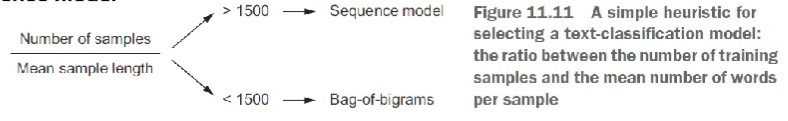

This intuitively makes sense: the input of a sequence model represents a richer and more complex space and thus it takes more data to map out that space; meanwhile a plain set of terms reside in a simpler space, you can train a logisitic regression on top using just a few hundreds or thousands of samples.